In [ ]:
!pip install texthero

  Using cached texthero-1.1.0-py3-none-any.whl (24 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
ERROR: preprocessing 0.1.13 has requirement nltk==3.2.4, but you'll have nltk 3.8.1 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import texthero as hero

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import sklearn
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Bidirectional, Embedding, LSTM, BatchNormalization, Dropout
from texthero import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Using TensorFlow backend.


In [ ]:
df_train=pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [ ]:
train, test = train_test_split(df_train, test_size = 0.3, random_state = 1)
print("Train:", train.shape)
print("Test:", test.shape)

Train: (111699, 8)
Test: (47872, 8)


#### Preprocessing : Cleaning the comments using texthero

https://texthero.org/docs/getting-started

In [ ]:
pipeline = [preprocessing.remove_digits, # Remove all blocks of digits
            preprocessing.remove_punctuation, # Remove all string.punctuation
            preprocessing.remove_diacritics,# Remove all accents from strings
            preprocessing.remove_whitespace, # Remove all white space between words
            preprocessing.remove_urls, # Remove urls
           ]

df_train = hero.clean(train['comment_text'], pipeline)
df_test = hero.clean(test['comment_text'], pipeline)


In [ ]:
target = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[target]
y_test = test[target]

In [ ]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='')
tokenizer.fit_on_texts(df_train.values)

#### Generating tokens: Break up sentences and paragraphs into smaller units so that meaning can be more easily ascribed.

In [ ]:
train_tokens = tokenizer.texts_to_sequences(df_train.values)
test_tokens = tokenizer.texts_to_sequences(df_test.values)

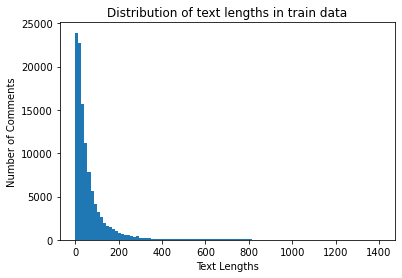

In [ ]:
text_lengths = [len(seq) for seq in train_tokens]
plt.hist(text_lengths, bins=100);
plt.title("Distribution of text lengths in train data");
plt.xlabel('Text Lengths');
plt.ylabel("Number of Comments");

#### Maximum comments are less than 150 and very few are more than 400 text length

In [ ]:
print(f'Mean length of text sequences: {np.mean(text_lengths)}') # mean length

Mean length of text sequences: 68.10441454265481


#### Padding to ensure that the input data is exactly the size and shape that the model expects.

In [ ]:
sequence_length = 300
X_train_seq = pad_sequences(train_tokens, maxlen = sequence_length,padding='post',truncating='post')
X_test_seq = pad_sequences(test_tokens, maxlen = sequence_length,padding='post',truncating='post')

#### LSTM preferred because: The "memory state" of the network, or "cell state," that memorizes data from earlier steps, is the fundamental concept of the LSTM which is helpful for comments classification.

In [ ]:
model = Sequential()
model.add(Input(shape=(None,)))

# adding Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=300,
                    input_length=pad_sequences, mask_zero=True))
# adding Dense layer
model.add(LSTM(units= 30, dropout=0.2, return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))    # adding Dropout layer
model.add(Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000300   
_________________________________________________________________
lstm (LSTM)                  (None, 30)                39720     
_________________________________________________________________
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [ ]:
model.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

In [ ]:
train_history = model.fit(X_train_seq, y_train,batch_size=32,epochs = 2)

Epoch 1/2
3491/3491 [==============================] - 881s 252ms/step - loss: 0.1018 - accuracy: 0.8250
Epoch 2/2
3491/3491 [==============================] - 879s 252ms/step - loss: 0.0525 - accuracy: 0.9766


In [ ]:
score = model.evaluate(X_test_seq, y_test)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

1496/1496 [==============================] - 67s 45ms/step - loss: 0.0538 - accuracy: 0.9912
Test Loss: 0.05381278693675995
Test Accuracy: 0.9912266135215759


In [ ]:
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [ ]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
df_test.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


In [ ]:
df_test['comment_text'][0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [ ]:
df_test_test = hero.clean(df_test['comment_text'], pipeline)
test_test_tokens = tokenizer.texts_to_sequences(df_test_test.values)
X_test_test__seq = pad_sequences(test_test_tokens, maxlen = sequence_length,padding='post',truncating='post')
y_test_prob = model.predict(X_test_test__seq)


In [ ]:
print(y_test_prob)

array([[9.80697393e-01, 2.51609206e-01, 9.71122742e-01, 1.36187077e-02,
        8.32509875e-01, 7.13480711e-02],
       [6.56917618e-05, 1.11135944e-06, 5.37240794e-06, 2.24305177e-06,
        1.39645917e-05, 2.03549007e-05],
       [4.30826843e-02, 2.22772360e-04, 3.96519899e-03, 1.38863921e-03,
        6.27708435e-03, 5.00899553e-03],
       ...,
       [1.16578267e-04, 1.32103314e-05, 9.94610491e-06, 3.03144998e-06,
        2.01083603e-05, 1.06370535e-05],
       [6.40797615e-03, 1.62839890e-04, 6.17057085e-04, 1.19380864e-04,
        1.26454234e-03, 8.27848911e-04],
       [8.70893717e-01, 4.23313081e-02, 5.27434289e-01, 1.92972422e-02,
        4.95283544e-01, 9.00343060e-02]], dtype=float32)

In [ ]:
y_test_prob_df = pd.DataFrame(y_test_prob)

In [ ]:
y_test_prob_df.rename(columns={"0": "toxic", "1": "severe_toxic","2": "obscene", "3": "threat","4": "insult", "5": "identity_hate"})
y_test_prob_df.head()

,0,1,2,3,4,5
0,0.980697,0.251609,0.971123,0.013619,0.832510,0.071348
1,0.000066,0.000001,0.000005,0.000002,0.000014,0.000020
2,0.043083,0.000223,0.003965,0.001389,0.006277,0.005009
3,0.000153,0.000005,0.000012,0.000007,0.000034,0.000049
4,0.048337,0.000103,0.003612,0.000938,0.005712,0.003460


In [ ]:
Result_binary = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')
for com in target:
        Result_binary[com] = y_test_prob


In [ ]:
Result_binary.to_csv('submission_binary.csv',index=False)

In [ ]:
Result_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.980697,0.980697,0.980697,0.980697,0.980697,0.980697
1,0000247867823ef7,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066
2,00013b17ad220c46,0.043083,0.043083,0.043083,0.043083,0.043083,0.043083
3,00017563c3f7919a,0.000153,0.000153,0.000153,0.000153,0.000153,0.000153
4,00017695ad8997eb,0.048337,0.048337,0.048337,0.048337,0.048337,0.048337
